In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
# keep the seed
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
data = pd.read_csv('./preprocessed_stock_data.csv')
data

,Unnamed: 0,Open,High,Low,Close,Volume,Dividends,Stock Splits,pct_change,log_change,...,7lower,14upper,14lower,21upper,21lower,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components
0,0,0.042625,0.044357,0.061568,0.047456,0.107174,0.0,0.0,0.517787,0.548932,...,0.067942,0.031156,0.064485,0.036004,0.059553,0.477328,0.513380,0.501912,0.481157,0.457737
1,1,0.046198,0.047697,0.064222,0.052403,0.125170,0.0,0.0,0.576838,0.606990,...,0.067942,0.031156,0.064485,0.036004,0.059553,0.474359,0.504980,0.489545,0.444376,0.343904
2,2,0.051045,0.054311,0.070137,0.059011,0.203814,0.0,0.0,0.595532,0.625195,...,0.067942,0.031156,0.064485,0.036004,0.059553,0.471392,0.496569,0.477192,0.407986,0.238861
3,3,0.054355,0.054052,0.067043,0.054129,0.258395,0.0,0.0,0.461438,0.492729,...,0.067942,0.031156,0.064485,0.036004,0.059553,0.468427,0.488148,0.464861,0.372221,0.148035
4,4,0.052516,0.053107,0.068273,0.056139,0.164915,0.0,0.0,0.541312,0.572162,...,0.067942,0.031156,0.064485,0.036004,0.059553,0.465463,0.479722,0.452560,0.337306,0.075471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,1253,0.964284,0.961627,0.970252,0.959658,0.054509,0.0,0.0,0.555639,0.586244,...,0.974627,0.953272,0.968878,0.964178,0.983405,0.492179,0.555084,0.563651,0.662728,0.942356
1254,1254,0.970462,0.962268,0.972815,0.958967,0.023481,0.0,0.0,0.515561,0.546726,...,0.976760,0.961817,0.966456,0.966198,0.982190,0.489208,0.546793,0.551344,0.627497,0.874926
1255,1255,0.972305,0.973590,0.973670,0.971723,0.011015,0.0,0.0,0.558905,0.589448,...,0.979069,0.973217,0.963304,0.974655,0.977735,0.486238,0.538473,0.539008,0.591497,0.788338
1256,1256,0.985638,0.989505,0.990706,0.983736,0.059854,0.0,0.0,0.556114,0.586711,...,0.982036,0.985314,0.963505,0.986335,0.973593,0.483267,0.530129,0.526652,0.554953,0.686319


In [4]:
data['y'] = data['Close']

num_cols = 32

x = data.iloc[:, :num_cols].values
y = data.iloc[:, num_cols].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (1006, 32) trainY: (1006,)
testX: (252, 32) testY: (252,)


In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super().__init__()
        
        # Encoder
        self.encoder_layers = nn.ModuleList()
        current_dim = input_dim
        
        for hidden_dim in hidden_dims:
            self.encoder_layers.append(
                nn.Sequential(
                    nn.Linear(current_dim, hidden_dim),
                    nn.ReLU()
                )
            )
            current_dim = hidden_dim
            
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])
        
        self.decoder_layers = nn.ModuleList()
        reversed_dims = list(reversed(hidden_dims))
        
        for i in range(len(reversed_dims) - 1):
            self.decoder_layers.append(
                nn.Sequential(
                    nn.Linear(reversed_dims[i], reversed_dims[i + 1]),
                    nn.ReLU()
                )
            )
            
        # Final output layer
        self.final_layer = nn.Sequential(
            nn.Linear(reversed_dims[-1], input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        for layer in self.encoder_layers:
            x = layer(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        for layer in self.decoder_layers:
            x = layer(x)
        return self.final_layer(x)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), z, mu, log_var

In [6]:
# train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
# model = VAE(input_dim=num_cols, hidden_dims=[400, 400, 400,10], latent_dim=10)

model = VAE(input_dim=32,  # Changed for 32 features
           hidden_dims=[484, 832, 1022, 138],  # New optimized dimensions
           latent_dim=36)  # 

train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), 
                         batch_size=32,  # Changed to optimal batch size
                         shuffle=False)

[1/300] Loss: 86.58068919181824
[2/300] Loss: 71.47941875457764
[3/300] Loss: 61.85355758666992
[4/300] Loss: 57.27815294265747
[5/300] Loss: 53.10436427593231
[6/300] Loss: 46.450416922569275
[7/300] Loss: 41.169501304626465
[8/300] Loss: 37.69359886646271
[9/300] Loss: 34.31332623958588
[10/300] Loss: 31.737075984477997
[11/300] Loss: 29.81758624315262
[12/300] Loss: 28.137028574943542
[13/300] Loss: 27.27190351486206
[14/300] Loss: 26.16976374387741
[15/300] Loss: 25.126606047153473
[16/300] Loss: 24.55049377679825
[17/300] Loss: 24.184091567993164
[18/300] Loss: 23.933537006378174
[19/300] Loss: 23.672828018665314
[20/300] Loss: 23.219186782836914
[21/300] Loss: 22.78431385755539
[22/300] Loss: 22.67929470539093
[23/300] Loss: 22.96129810810089
[24/300] Loss: 23.35698312520981
[25/300] Loss: 23.189656376838684
[26/300] Loss: 22.77388834953308
[27/300] Loss: 22.827596485614777
[28/300] Loss: 23.255143880844116
[29/300] Loss: 23.37484782934189
[30/300] Loss: 23.086842477321625
[31/30

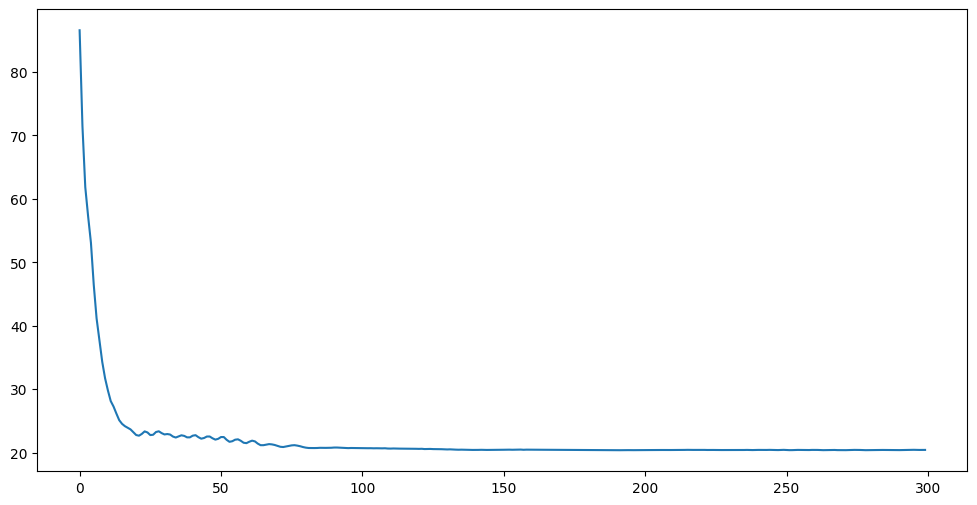

In [7]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 6.536830781589905e-06
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [8]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [9]:
# our existing time series window function
def time_series_window(x, y, window_size):
    """
    Args:
        x: Input features array, shape (n_samples, n_features)
        y: Target values array, shape (n_samples, 1)
        window_size: Size of the sliding window
        
    Returns:
        tuple: (
            windowed_x: Feature windows, shape (n_samples-window, window_size, n_features)
            windowed_y: Single target values, shape (n_samples-window, 1)
            windowed_y_gan: Target windows, shape (n_samples-window, window_size+1, 1)
        )
    """
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    if not isinstance(y, np.ndarray):
        y = np.array(y)
        
    n_samples = len(x) - window_size
    
    windowed_x = np.zeros((n_samples, window_size, x.shape[1]))
    windowed_y = np.zeros((n_samples, 1))
    windowed_y_gan = np.zeros((n_samples, window_size + 1, 1))
    
    for i in range(n_samples):
        windowed_x[i] = x[i:i + window_size]
        windowed_y[i] = y[i + window_size]
        windowed_y_gan[i] = y[i:i + window_size + 1]
    
    return (torch.from_numpy(windowed_x).float(),
            torch.from_numpy(windowed_y).float(),
            torch.from_numpy(windowed_y_gan).float())

In [10]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [11]:
train_x_slide, train_y_slide, train_y_gan = time_series_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = time_series_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([1003, 3, 68]) train_y: torch.Size([1003, 1]) train_y_gan: torch.Size([1003, 4, 1])
test_x: torch.Size([249, 3, 68]) test_y: torch.Size([249, 1]) test_y_gan: torch.Size([249, 4, 1])


In [12]:
# GRU + CNN
# class Generator(nn.Module):
#     def __init__(self, input_size):
#         super().__init__()
#         self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
#         self.gru_2 = nn.GRU(1024, 512, batch_first = True)
#         self.gru_3 = nn.GRU(512, 256, batch_first = True)
#         self.linear_1 = nn.Linear(256, 128)
#         self.linear_2 = nn.Linear(128, 64)
#         self.linear_3 = nn.Linear(64, 1)
#         self.dropout = nn.Dropout(0.2)

#     def forward(self, x):
#         use_cuda = 1
#         device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
#         h0 = torch.zeros(1, x.size(0), 1024).to(device)
#         out_1, _ = self.gru_1(x, h0)
#         out_1 = self.dropout(out_1)
#         h1 = torch.zeros(1, x.size(0), 512).to(device)
#         out_2, _ = self.gru_2(out_1, h1)
#         out_2 = self.dropout(out_2)
#         h2 = torch.zeros(1, x.size(0), 256).to(device)
#         out_3, _ = self.gru_3(out_2, h2)
#         out_3 = self.dropout(out_3)
#         out_4 = self.linear_1(out_3[:, -1, :])
#         out_5 = self.linear_2(out_4)
#         out = self.linear_3(out_5)
#         return out

class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 652, batch_first=True)  # Changed to 652
        self.gru_2 = nn.GRU(652, 893, batch_first=True)        # Changed to 893
        self.gru_3 = nn.GRU(893, 482, batch_first=True)        # Changed to 482
        self.linear_1 = nn.Linear(482, 164)                    # Changed to 164
        self.linear_2 = nn.Linear(164, 115)                    # Changed to 115
        self.linear_3 = nn.Linear(115, 1)
        self.dropout = nn.Dropout(0.153848576505225)           # New dropout rate

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 652).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)

        h1 = torch.zeros(1, x.size(0), 893).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)

        h2 = torch.zeros(1, x.size(0), 482).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)

        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
#         self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
#         self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
#         self.linear1 = nn.Linear(128, 220)
#         self.batch1 = nn.BatchNorm1d(220)
#         self.linear2 = nn.Linear(220, 220)
#         self.batch2 = nn.BatchNorm1d(220)
#         self.linear3 = nn.Linear(220, 1)
#         self.leaky = nn.LeakyReLU(0.01)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         conv1 = self.conv1(x)
#         conv1 = self.leaky(conv1)
#         conv2 = self.conv2(conv1)
#         conv2 = self.leaky(conv2)
#         conv3 = self.conv3(conv2)
#         conv3 = self.leaky(conv3)
#         flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
#         out_1 = self.linear1(flatten_x)
#         out_1 = self.leaky(out_1)
#         out_2 = self.linear2(out_1)
#         out_2 = self.relu(out_2)
#         out_3 = self.linear3(out_2)
#         out = self.sigmoid(out_3)
#         return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 50, kernel_size=3, stride=1, padding='same')  # 50 filters
        self.conv2 = nn.Conv1d(50, 60, kernel_size=3, stride=1, padding='same') # 60 filters
        self.conv3 = nn.Conv1d(60, 211, kernel_size=3, stride=1, padding='same') # 211 filters
        self.linear1 = nn.Linear(211, 155)  # Changed to 155
        self.linear2 = nn.Linear(155, 155)  # Keep same dimension
        self.linear3 = nn.Linear(155, 1)
        self.leaky = nn.LeakyReLU(0.0666677684638632)  # Optimized slope
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2741225785366103)  # Optimized dropout

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        return torch.sigmoid(out_3)

In [13]:
# CUDA setup remains the same
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

# Update batch size to optimized value from tuning
batch_size = 32  # Changed from 128 to match optimal value found by Optuna

# Update learning rates to the optimized values for Generator and Discriminator separately
learning_rate_G = 3.319668704256778e-05  # Optimized Generator learning rate
learning_rate_D = 9.506230598366327e-05  # Optimized Discriminator learning rate

# Keep number of epochs the same as it worked well in your implementation
num_epochs = 165

# Update the DataLoader with new batch size
trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), 
                           batch_size=batch_size, 
                           shuffle=False)

# Initialize models and send to device
modelG = Generator(num_cols + 36).to(device)  # Note: latent_dim is now 36
modelD = Discriminator().to(device)

# Keep criterion the same
criterion = nn.BCELoss()

# Update optimizers with separate learning rates
optimizerG = torch.optim.Adam(modelG.parameters(), 
                             lr=learning_rate_G, 
                             betas=(0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), 
                             lr=learning_rate_D, 
                             betas=(0.0, 0.9))

# Initialize history tracking
histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)

# Training loop remains largely the same but with smaller batches
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis=1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)

        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 

    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/165] LossD: 44.3444287776947 LossG:21.601266145706177
[2/165] LossD: 44.372796177864075 LossG:22.123636186122894
[3/165] LossD: 44.36039662361145 LossG:22.182265996932983
[4/165] LossD: 44.35997915267944 LossG:22.18222886323929
[5/165] LossD: 44.35966241359711 LossG:22.182473301887512
[6/165] LossD: 44.359713554382324 LossG:22.182789087295532
[7/165] LossD: 44.36017036437988 LossG:22.181856155395508
[8/165] LossD: 44.36076533794403 LossG:22.181716084480286
[9/165] LossD: 44.361372590065 LossG:22.181217849254608
[10/165] LossD: 44.36131680011749 LossG:22.18008929491043
[11/165] LossD: 44.361130356788635 LossG:22.18099755048752
[12/165] LossD: 44.360939145088196 LossG:22.180583953857422
[13/165] LossD: 44.36088013648987 LossG:22.180639803409576
[14/165] LossD: 44.36086070537567 LossG:22.181271255016327
[15/165] LossD: 44.36091637611389 LossG:22.17953187227249
[16/165] LossD: 44.3607040643692 LossG:22.179211676120758
[17/165] LossD: 44.36051607131958 LossG:22.18058568239212
[18/165] Lo

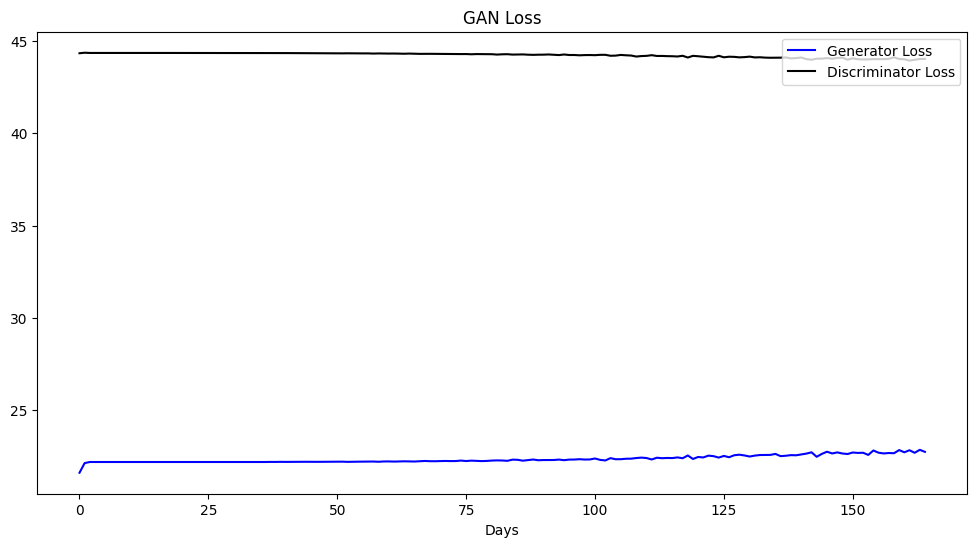

In [14]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [15]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:0.020712024222373254


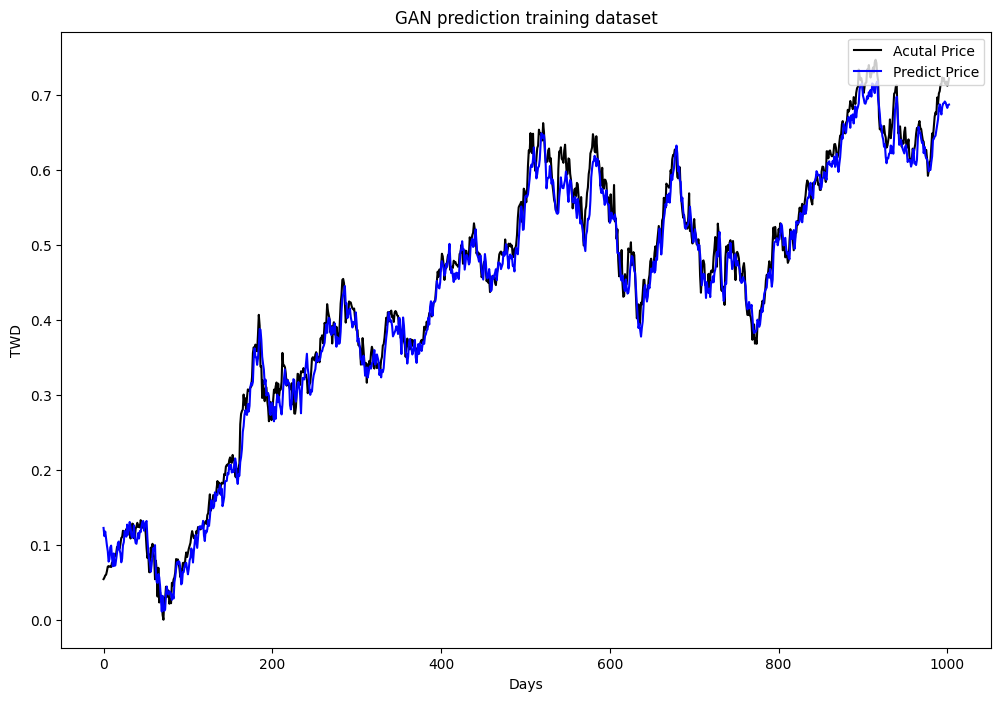

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:0.0579279739941365


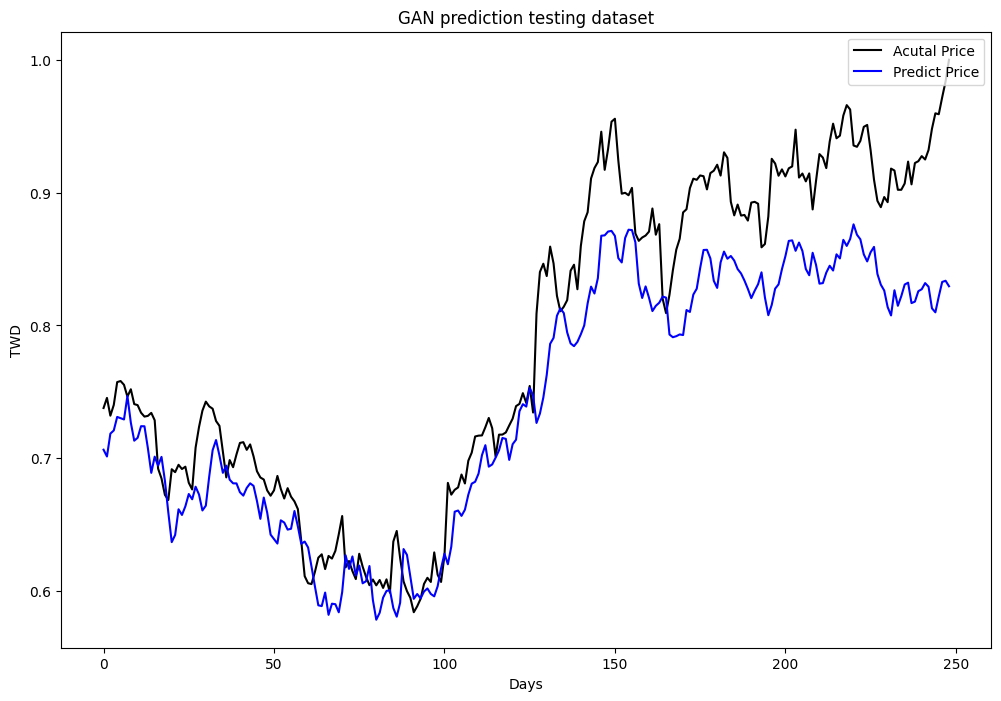

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_test_true, y_test_pred)
print(f'Testing dataset MSE:{MSE}')
print(f'Testing dataset RMSE:{RMSE}')
print(f'Testing dataset MAE:{MAE}')